# Tensorboard Tutorial

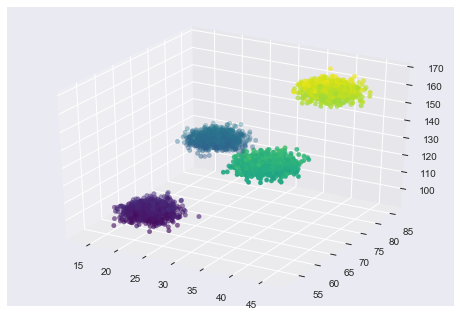

In [18]:
from data.synthetic import get_tf_normal_dataset

dataset = get_tf_normal_dataset(1000, xy_features=(2,1), plot=True)

# Sample Model: GMM MDN

In [19]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from mpl_toolkits import mplot3d
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

In [20]:
class GMM:
    """Gaussian Mixture Density Network."""
    def __init__(self, x_features=2, y_features=1, n_components=4, n_hidden=50, verbose=False):
        self.x_features = x_features  # no. of input features
        self.y_features = y_features  # no. of output features
        self.n_components = n_components  # no. of components
        self.n_hidden = n_hidden  # no. of hidden units 
        self.verbose = verbose
        self.build()
    
    def build(self):
        """Compile TF model."""
        input = tf.keras.Input(shape=(self.x_features,))
        layer = tf.keras.layers.Dense(self.n_hidden, activation='tanh')(input)

        mu = tf.keras.layers.Dense(self.n_components * self.y_features)(layer)
        sigma = tf.keras.layers.Dense(self.n_components * self.y_features, activation='exponential')(layer)
        pi = tf.keras.layers.Dense(self.n_components, activation='softmax')(layer)

        self.model = tf.keras.models.Model(input, [pi, mu, sigma])
        self.optimizer = tf.keras.optimizers.Adam()
        
        if self.verbose:
            print(self.model.summary())
        
    def tfdGMM(self, pi, mu, sigma):
        """Tensorflow Probability Distributions GMM."""
        mu = tf.reshape(mu, (self.n_components, self.y_features))
        sigma = tf.reshape(sigma, (self.n_components, self.y_features))
        return tfd.MixtureSameFamily(
            mixture_distribution=tfd.Categorical(probs=pi),
            components_distribution=tfd.MultivariateNormalDiag(loc=mu,
                                                               scale_diag=sigma))

    def loss(self, y, pi, mu, sigma):
        """Loss function, negative log-likelihood."""
        samples = pi.shape[0]
        losses = 0
        for i in range(samples):
            gmm = self.tfdGMM(pi[i], mu[i], sigma[i])
            loss = gmm.log_prob(y[i])
            loss = tf.negative(loss)
            losses += loss
        return losses / samples
    
    @tf.function
    def train_step(self, X, y):
        """TF train function."""
        with tf.GradientTape() as t:
            pi, mu, sigma = self.model(X, training=True)
            loss = self.loss(y, pi, mu, sigma)
        gradients = t.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        return loss
    
    def fit(self, dataset, epochs=1000, plot=False):
        """Fit with TF dataset."""
        current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
        train_summary_writer = tf.summary.create_file_writer(train_log_dir)
        
        for epoch in range(epochs):
            for train_x, train_y in dataset:
                loss = self.train_step(train_x, train_y)
            with train_summary_writer.as_default():
                tf.summary.scalar('NLL', loss, step=epoch)
            
    def prob(self, X, y):
        """Compute probability of y given X."""
        pi, mu, sigma = self.model(X) 
        samples = pi.shape[0]
        y_prob = []
        for i in range(samples):
            y_prob.append(self.tfdGMM(pi[i], mu[i], sigma[i]).prob(y[i]).numpy())
        return np.array(y_prob)
        
    def sample(self, X):
        """Sample y given X."""
        pi, mu, sigma = self.model(X) 
        samples = pi.shape[0]
        y_pred = []
        for i in range(samples):
            y_pred.append(self.tfdGMM(pi[i], mu[i], sigma[i]).sample().numpy())
        return np.array(y_pred)
    
    def sample_fixed(self, X_fixed, count=20):
        X = np.stack([np.full(count, fill_value=x) for x in X_fixed], axis=1)
        return self.sample(X)

In [22]:
gmm = GMM(x_features=dataset.element_spec[0].shape[1],
          y_features=dataset.element_spec[1].shape[1],
          n_components=4,
          n_hidden=10, verbose=True)
gmm.fit(dataset, epochs=300, plot=True)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 10)           30          input_2[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 4)            44          dense_6[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 4)            44          dense_6[0][0]                    
____________________________________________________________________________________________

In [21]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [27]:
%tensorboard --logdir logs/gradient_tape --host localhost

Reusing TensorBoard on port 6006 (pid 1536), started 0:01:15 ago. (Use '!kill 1536' to kill it.)